# Time series analysis of electric production dataset from kaggle;

# dataset link- https://www.kaggle.com/datasets/shenba/time-series-datasets/data

# problem(s) definition:
1. Predict future electric production levels.
2. Analyze whether production fluctuates during specific times such as spring or summer.
3. Identify unusual production patterns such as sudden drops or spikes.

In [55]:
# key libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # test
from statsmodels.tsa.arima.model import ARIMA # Model prediction.
from statsmodels.tsa.seasonal import seasonal_decompose # for breaking down the time series into trend, seasonality, and residual components.
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [56]:
# data loading
df = pd.read_csv('Electric_Production.csv')

In [57]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


# data inspection

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [59]:
df.shape

(397, 2)

In [60]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [61]:
df.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

# eda & preprocessing

In [62]:
# renaming energy production column and confirmation
df = df.rename(columns={'IPG2211A2N': 'EPRODUCTION'})
df.columns

Index(['DATE', 'EPRODUCTION'], dtype='object')

In [63]:
#converting date to datetime and confirming
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,EPRODUCTION
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [64]:
# setting datetime as an index, to enable time-based indexing and easier analysis.
df.set_index('DATE', inplace=True)

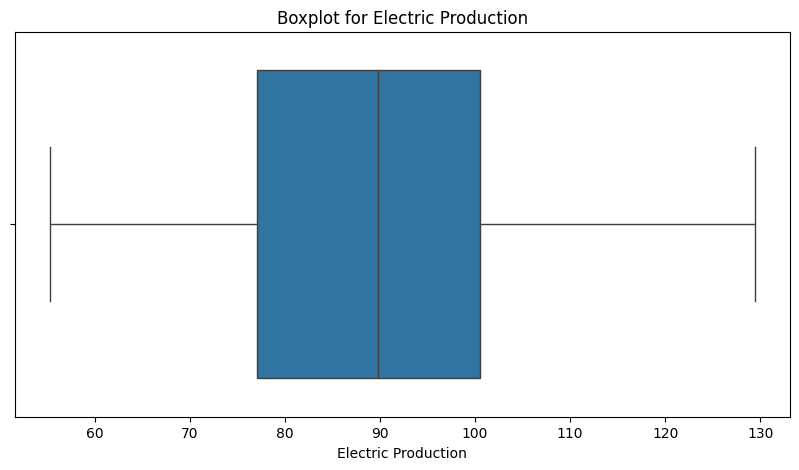

In [65]:
# checking for outliers using a box plot

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='EPRODUCTION')
plt.title("Boxplot for Electric Production")
plt.xlabel("Electric Production")
plt.show()

<Axes: xlabel='DATE', ylabel='EPRODUCTION'>

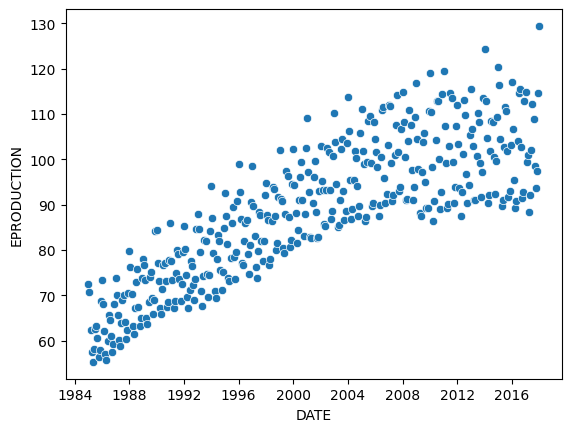

In [66]:
# plotting the data to inspect production over time using scatter and line plots
# primarily checking for trends and seasonality
# scatterplot
sns.scatterplot(df, x='DATE', y='EPRODUCTION')

<Axes: xlabel='DATE'>

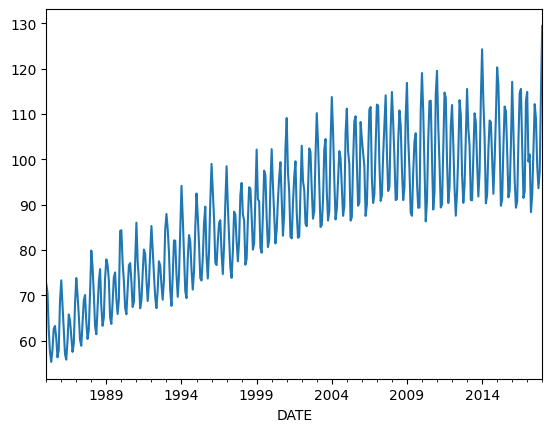

In [67]:
# line plot
df.EPRODUCTION.plot()

In [68]:
# checking for stationarity
result = adfuller(df['EPRODUCTION'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.256990350047244
p-value: 0.18621469116586792


P-value is greater than 0.05 therefore our data in non-stationary and it needs transforming.

In [69]:
# transformation through differencing 
# differencing makes the data stationary by taking the difference between consecutive data points, which helpsto show trends.
df_diff = df.diff().dropna()

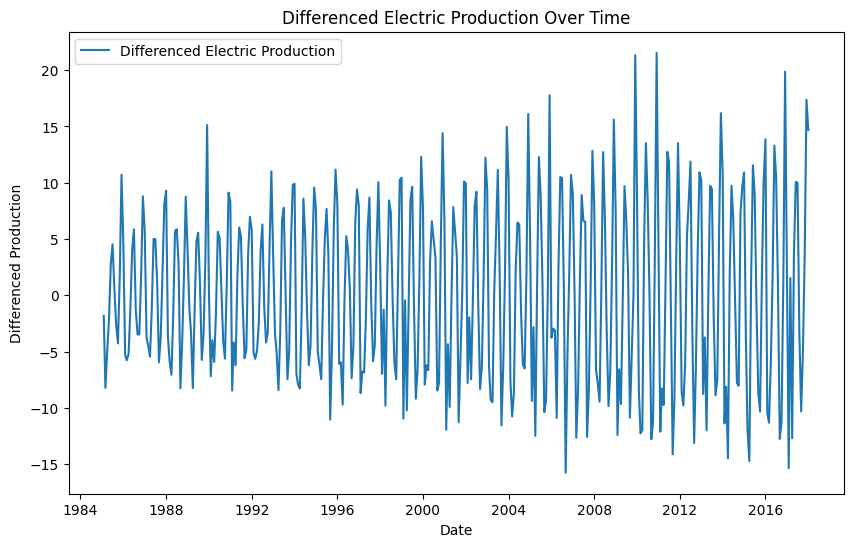

In [70]:
# visualization to confirm the transformation
plt.figure(figsize=(10, 6))
plt.plot(df_diff, label='Differenced Electric Production')
plt.title('Differenced Electric Production Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Production')
plt.legend()
plt.show()

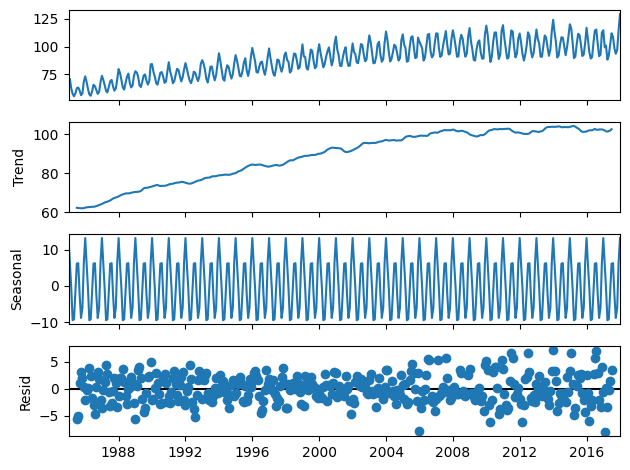

In [71]:
# Decomposing the Time Series for Seasonal Effect Analysis
# is there a consistent pattern or cycle in the dataset?

decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

Seasonal decomposition splits the time series into 3 components above:

1. Trend: The overall direction the data is moving (increasing, decreasing or stable).
2. Seasonality: Patterns that repeat at regular intervals (e.g., yearly, monthly).
3. Residual: The leftover part after removing the trend and seasonality (noise).

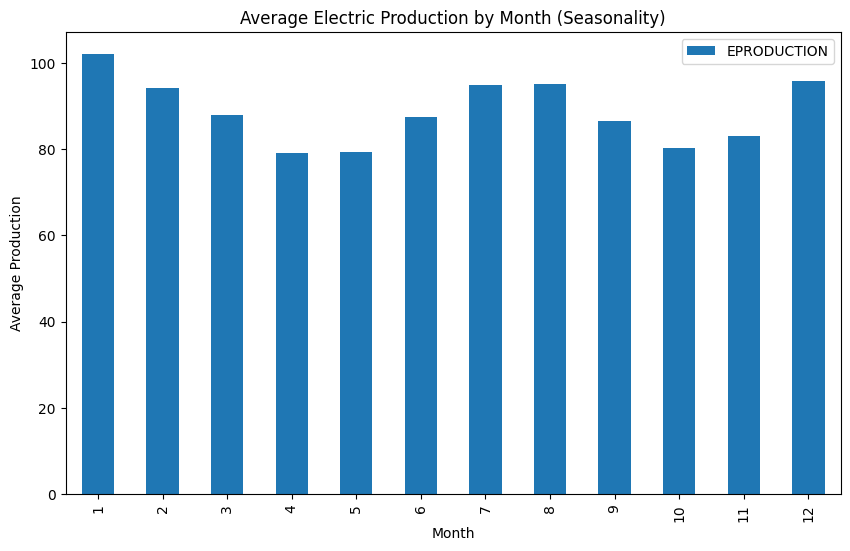

In [72]:
# Monthly Seasonality, Further Seasonal Analysis.
monthly_seasonality = df.groupby(df.index.month).mean()
monthly_seasonality.plot(kind='bar', figsize=(10, 6))
plt.title('Average Electric Production by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Production')
plt.show()

To visualizes how production varies by month,for helping to understand seasonality, for my case higher production is in summer months of January, August and December.

# model creation

In [73]:
# ARIMA Model for Demand Forecasting
model = ARIMA(df, order=(5, 1, 0))  # Adjust order based on ACF/PACF plots if needed
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [74]:
# Model Evaluation
# Train and test split
train = df[:-12]  # Train on all data except the last 12 months to be used for testing
test = df[-12:]   

In [75]:
# Fit ARIMA model on the training set
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()


/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kingoriwangui/jimmygmc_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [76]:
# Forecast for the next 12 months (same period as the test set)

forecast = model_fit.forecast(steps=12)

In [91]:
# checking whether forecast size matches test size
print(f"Forecast size: {len(forecast)}, Test size: {len(test)}")

Forecast size: 12, Test size: 12


In [92]:
# Convert forecast to a series with the same index as the test set
test['forecast'] = pd.Series(forecast, index=test.index)

/var/folders/js/8bnyws5d18x0g67dk4jcfp8w0000gn/T/ipykernel_5371/4214969213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = pd.Series(forecast, index=test.index)


In [93]:
# Comparing the actual and forecasted values before plotting
comparison_df = pd.DataFrame({'Actual': test['EPRODUCTION'], 'Forecast': test['forecast']})
print(comparison_df)

              Actual    Forecast
DATE                            
2017-02-01   99.4901  110.521605
2017-03-01  101.0396   99.497350
2017-04-01   88.3530   92.268199
2017-05-01   92.0805   97.845563
2017-06-01  102.1532  108.436218
2017-07-01  112.1538  114.140933
2017-08-01  108.9312  109.852617
2017-09-01   98.6154   99.925009
2017-10-01   93.6137   94.489325
2017-11-01   97.3359   98.471478
2017-12-01  114.7212  107.481857
2018-01-01  129.4048  112.595004


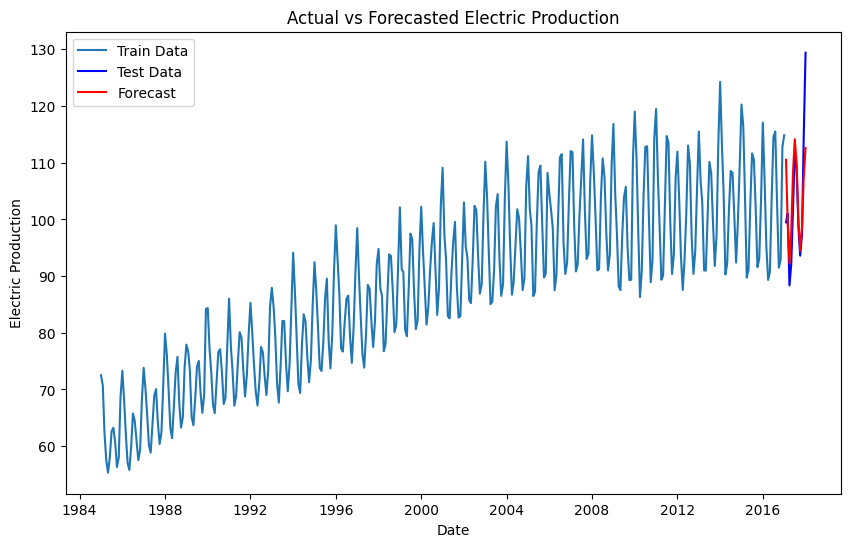

In [94]:
# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test['EPRODUCTION'], label='Test Data', color='blue')
plt.plot(test.index, test['forecast'], label='Forecast', color='red')
plt.title('Actual vs Forecasted Electric Production')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.legend()
plt.show()

In [95]:
# model perfomance evaluation
mae = mean_absolute_error(test['EPRODUCTION'], test['forecast'])
rmse = np.sqrt(mean_squared_error(test['EPRODUCTION'], test['forecast']))
mape = np.mean(np.abs((test['EPRODUCTION'] - test['forecast']) / test['EPRODUCTION'])) * 100

In [96]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 4.901294699929377
Root Mean Squared Error (RMSE): 6.8047781416156345
Mean Absolute Percentage Error (MAPE): 4.57%


# Evaluation metrics results summary:

1. MAE of 0 indicates no error in predictions. My forecast is on average, 4.9 units off from the actual values meaning it is good but with room for improvement
2. An RMSE of 0 indicates perfect predictions therefore Lower values are better, my rmse is slightly negative and might need corrective action
3. MAPE of 0% means perfect accuracy implying Lower percentages are better, my mape is below 5 which is considered good.

# Model improvement considerations:
1. model tuning or trying different models to reduce the average error.
2. consider smoothing techniques to minimize larger deviations.
3. 
